# "Characterizing and addressing the issue of oversmoothing in neural autoregressive sequence modeling". Experiment results

In [19]:
import pandas as pd
import numpy as np
from IPython.core.display import display
import itertools
from matplotlib import pyplot as plt
import os

import collections
from cycler import cycler
from matplotlib.ticker import ScalarFormatter

import collections

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

%matplotlib inline

In [2]:
from IPython.display import set_matplotlib_formats

def plt_to_pdf(size=22):
    set_matplotlib_formats('pdf')
    #font = {'family' : 'Times New Roman',
    #        'weight' : 'normal',
    #        'size'   : size}
    #matplotlib.rc('font', **font)
    
def plt_to_default():
    set_matplotlib_formats('png')
    plt.rcdefaults()

In [4]:
experiments = {
    'iwslt17 DE-EN': 'finetune_iwslt17_oversmoothing_grid_label_smoothing_de',
    'iwslt17 FR-EN': 'finetune_iwslt17_oversmoothing_grid_label_smoothing_fr',
    'iwslt17 ZH-EN': 'finetune_iwslt17_oversmoothing_grid_label_smoothing_zh',
    'wmt19 RU-EN': 'finetune_wmt19_ruen_osl',
    'wmt19 DE-EN': 'finetune_wmt19_deen_osl',
    'wmt19 EN-DE': 'finetune_wmt19_ende_osl',
    'wmt16 EN-DE': 'finetune_wmt16_ende_osl',

}

In [17]:
def filter_models_df(dfs, params):
    selected_ids = {}
    for experiment, df in dfs.items():
        selected_ids[experiment] = []
        for i in range(df.index.size):
            eq = 0
            for j in range(df.columns.size):
                for param in params:
                    if param == df.columns[j] and df.iloc[i, j] in params[param]:
                        eq += 1
            if eq == len(params):
                selected_ids[experiment] += [i]
    return selected_ids

In [44]:
def draw_plots_oversmoothing(experiments, metric, base_path, separately=False, 
                             on_one_plot=False, metric_name=None, target=False, 
                             xaxis_metric=None, beams=(1, 5, 100, 250, 500, 750, 1000), 
                             axis=None, figsize=(7,5), print_title=False):
    to_return = {}
    if separately:
        for i, exp in enumerate(experiments):
            fig, axis = plt.subplots(1, 1, figsize=figsize)
            output = draw_plot_wrt_beam_oversmoothing(axis=axis, exp_name=exp, 
                                                      metric=metric, 
                                                      model_name=experiments[exp], 
                                                      base_path=base_path, metric_name=metric_name,
                                                      target=target, xaxis_metric=xaxis_metric, 
                                                      beams=beams, print_title=print_title, exp_i = i)
            to_return[exp] = output
    elif on_one_plot:
        if axis is None:
            fig, axis = plt.subplots(1, 1, figsize=figsize)
        for i, exp in enumerate(experiments):
            output = draw_plot_wrt_beam_oversmoothing(axis=axis, exp_name=exp, 
                                                      metric=metric, model_name=experiments[exp], 
                                                      base_path=base_path, 
                                                      metric_name=metric_name, 
                                                      target=target, xaxis_metric=xaxis_metric, 
                                                      beams=beams, exp_i = i, print_title=print_title)
            to_return[exp] = output
    else:
        subplots = np.ceil(len(experiments) / 2)
        fig, axes = plt.subplots(int(subplots), 2, figsize=(15, subplots * 7))
        axes = axes.flatten()
        for i, exp in enumerate(experiments):
            output = draw_plot_wrt_beam_oversmoothing(axes[i], exp_name=exp, metric=metric, 
                                                      model_name=experiments[exp], 
                                                      base_path=base_path, 
                                                      metric_name=metric_name, xaxis_metric=xaxis_metric,
                                                      beams=beams, exp_i = i,
                                                      print_title=print_title)
            to_return[exp] = output
    return to_return


def draw_plot_wrt_beam_oversmoothing(axis, metric, model_name, exp_name, base_path, 
                                     metric_name=None, target=False, xaxis_metric=None, 
                                     print_title=False, beams=(1, 5, 100, 250, 500, 750, 1000),
                                     exp_i=0):

    markercycle = ['o', '+', 'x', '*', '.', 'X']
    #axis.set_prop_cycle(colorcycle*markercycle)
    values, stds = {}, {}
    for beam in beams:
        values[beam] = {}
        stds[beam] = {}
        res_path = f'{base_path}/{model_name}/metrics_{model_name}_beam{beam}.csv'
        if not os.path.exists(res_path):
            continue
        metrics = pd.read_csv(res_path, index_col=0)
        res = avg_by_seeds(metrics, params={'OSL weight'}, metrics={metric}, precision=6)
        if xaxis_metric is not None:
            res = avg_by_seeds(metrics, params={'OSL weight'}, metrics={metric, xaxis_metric}, precision=6)
        if len(res) == 0:
            continue
        for i, (weight, value) in enumerate(zip(res['OSL weight'], res[metric])):
            if weight == 1.0:
                continue
            if isinstance(value, str):
                value, std = value.split('+-')
            else:
                value, std = value, 0
            value, std = float(value), float(std)
            xaxis_value = round(weight, 2)
            if xaxis_metric is not None:
                if isinstance(res[xaxis_metric].iloc[i], str):
                    xaxis_value, std = res[xaxis_metric].iloc[i].split('+-')
                else:
                    xaxis_value, std = res[xaxis_metric].iloc[i], 0
                xaxis_value, std = float(xaxis_value), float(std)
                xaxis_value = round(xaxis_value, 2)
            values[beam][xaxis_value] = value
            stds[beam][xaxis_value] = std      
            if metric == 'T False EOS R avg':
                values[beam][xaxis_value] /= dict_size[exp_name]
                stds[beam][xaxis_value] /= dict_size[exp_name]
            if metric == 'OS loss':
                values[beam][xaxis_value] /= test_size[exp_name]
                stds[beam][xaxis_value] /= test_size[exp_name]
    
    y_max_limit = 0
    
    to_return = {}
    for i, beam in enumerate(values):
        values[beam] = collections.OrderedDict(sorted(values[beam].items()))
        stds_down = [values[beam][xaxis_value] - stds[beam][xaxis_value] for xaxis_value in values[beam]]
        stds_up = [values[beam][xaxis_value] + stds[beam][xaxis_value] for xaxis_value in values[beam]]
        if not target:
            axis.plot(values[beam].keys(), values[beam].values(), marker=markercycle[(i+exp_i)%len(markercycle)], label=f'beam {beam}', linewidth=1.2)
        else:
            axis.plot(values[beam].keys(), values[beam].values(), marker=markercycle[(i+exp_i)%len(markercycle)], label=f'{exp_name}', linewidth=1.2)
        #axis.scatter(values[neos].keys(), values[neos].values(), marker='o', label=f'{neos}', s=20 * beam_size[neos])
        if 'WMT' not in exp_name:
            axis.fill_between(values[beam].keys(), stds_down, stds_up, alpha=0.2)
        to_return[beam] = (values[beam].keys(), values[beam].values(), stds_down, stds_up)
        
        if max(values[beam].values()) > y_max_limit:
            y_max_limit = max(values[beam].values())
            

    if metric_name is None:
        metric_name = metric
    axis.set_xlabel('Weight $\\alpha$')
    axis.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 0.95])
    axis.set_xlim(0, 0.95)
    
    if xaxis_metric == 'OS rate':
        axis.set_xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7])
        axis.set_xlim(0, 0.75)
        
    if metric == 'OS rate':
        axis.set_ylim(0, y_max_limit*1.1)
    
    if metric == 'PPL':
        axis.set_ylim(2.5, 9)
    
    elif metric == 'T NTerm LL Avg':
        axis.set_ylim(-90, -10)
        axis.set_yscale('symlog')
        axis.set_yticks([-10,-20,-30,-40,-50,-60,-70,-80,-90])
        axis.yaxis.set_major_formatter(ScalarFormatter())
        
    elif metric == 'BLEU rel':
        axis.set_yticks([-1, 0, 1, 2, 3])
        axis.set_ylim(-1, 3.05)
    
    elif metric == 'LR seq':
        axis.set_yticks([1, 1.25, 1.5, 1.75, 2, 2.25, 2.4])
        axis.set_ylim(0.99, 2.4)
    
    ylabel_mapping = {
        'OS rate': "Oversmoothing rate",
        'OS loss': "Oversmoothing loss",
        'T False EOS R avg': 'Norm. rank of $\\left<\\mathrm{eos}\\right>$',
        'T NTerm LL Avg': 'Avg. $\\log p(\\left<\\mathrm{eos}\\right>|y_{\\mathrm{prefix}})$',
        'PPL': 'Perplexity',
        '|T|/|G| mean': 'Reference to generated length ratio'
    }
    
    ylabel = ylabel_mapping[metric_name] if metric_name in ylabel_mapping else metric_name
    axis.set_ylabel(ylabel)
    
    if print_title:
        axis.set_title(f'Task: {exp_name}', fontsize=16)
    # use legend
    axis.legend(fontsize=12)
    axis.grid()
    return to_return, axis

def avg_by_seeds(result_df, params, metrics, precision=4):
    unique_values = {}
    for param in params:
        unique_values[param] = result_df[param].unique().tolist()

    grid = (dict(zip(unique_values, x)) for x in itertools.product(*unique_values.values()))
    result = []
    for setup in grid:
        setup_unwrapped = {}
        for param in setup:
            setup_unwrapped[param] = {setup[param]}
        selected_ids = filter_models_df({'res': result_df}, setup_unwrapped)['res']
        result += [setup]
        data = result_df.iloc[selected_ids, :].drop_duplicates('seed')
        for metric in metrics:
            if len(data[metric]) > 1:
                result[-1][metric] = f'{round(data[metric].mean(), precision)} +- {round(data[metric].std(), precision)}'
            else:
                result[-1][metric] = round(data[metric].mean(), precision)
    return pd.DataFrame(result)

In [34]:
dict_size = {
    'iwslt17 DE-EN': 7336,
    'iwslt17 FR-EN': 7368,
    'iwslt17 ZH-EN': 7360,
    'wmt19 RU-EN': 31640,
    'wmt19 DE-EN': 42024,
    'wmt19 EN-DE': 42024,
    'wmt16 EN-DE': 32768
}

test_size = {
    'iwslt17 DE-EN': 8079,
    'iwslt17 FR-EN': 8597,
    'iwslt17 ZH-EN': 8549,
    'wmt19 RU-EN': 2000,
    'wmt19 DE-EN': 2000,
    'wmt19 EN-DE': 2000,
    'wmt16 EN-DE': 3000
}



beam_size = {
    1: 0,
    5: 1,
    100: 2,
    250: 3,
    500: 4,
    750: 5,
    1000: 6
}

In [35]:
import matplotlib.font_manager
plt_to_pdf(16)

/state/partition1/job-13197620/ipykernel_43202/4099449698.py:4: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('pdf')


In [37]:
plt_to_default()

/state/partition1/job-13197620/ipykernel_43202/4099449698.py:11: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('png')


### Figure 1: Oversmoothing rate

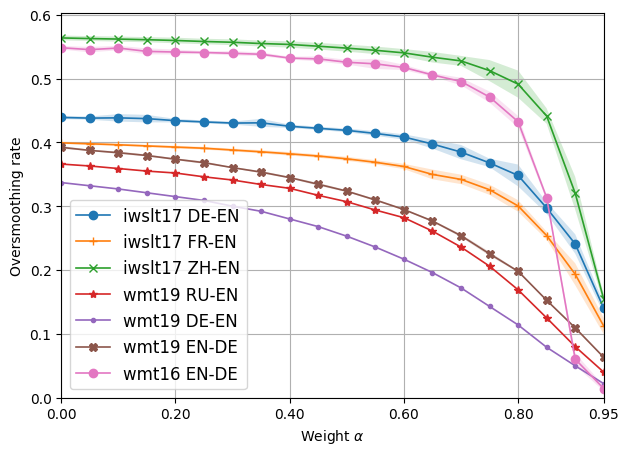

In [38]:
t = draw_plots_oversmoothing(experiments, 'OS rate', on_one_plot=True, 
                             base_path='/scratch/mae9785/oversmoothing_results_1512/', 
                             target=True,  beams=(5,),
                             print_title=False)

### Figure 2: Log-probabilities and Normalized rank

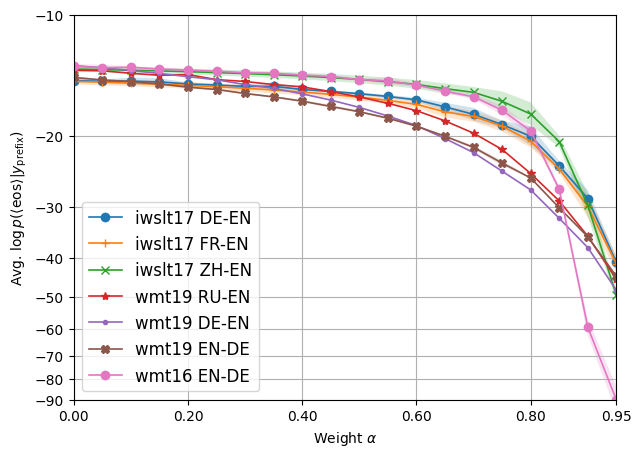

In [39]:
t = draw_plots_oversmoothing(experiments, 'T NTerm LL Avg', on_one_plot=True, 
                             base_path='/scratch/mae9785/oversmoothing_results_1512/', 
                             target=True,  beams=(5,),
                             print_title=False)

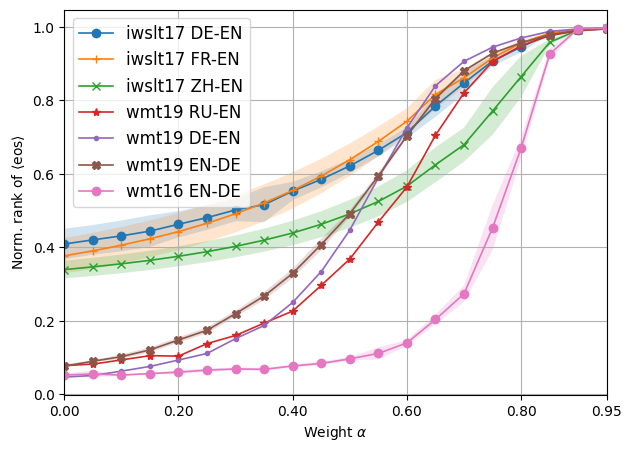

In [40]:
t = draw_plots_oversmoothing(experiments, 'T False EOS R avg', on_one_plot=True, 
                             base_path='/scratch/mae9785/oversmoothing_results_1512/', 
                             target=True,  beams=(5,),
                             print_title=False)

### Figure 3: Perplexity

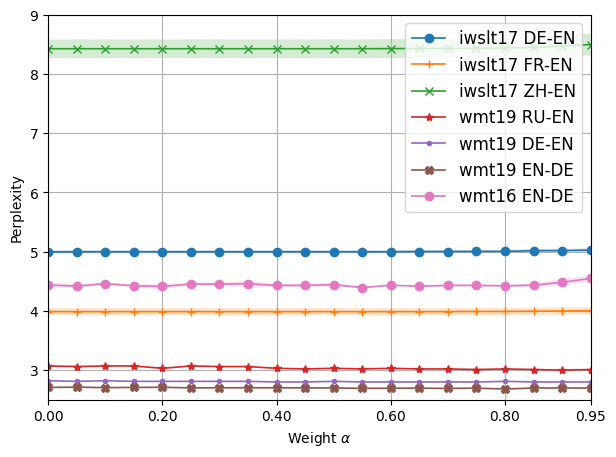

In [41]:
t = draw_plots_oversmoothing(experiments, 'PPL', on_one_plot=True, 
                             base_path='/scratch/mae9785/oversmoothing_results_1512/', 
                             target=True,  beams=(5,),
                             print_title=False)

### Figure 4: Sentence-level length ratio

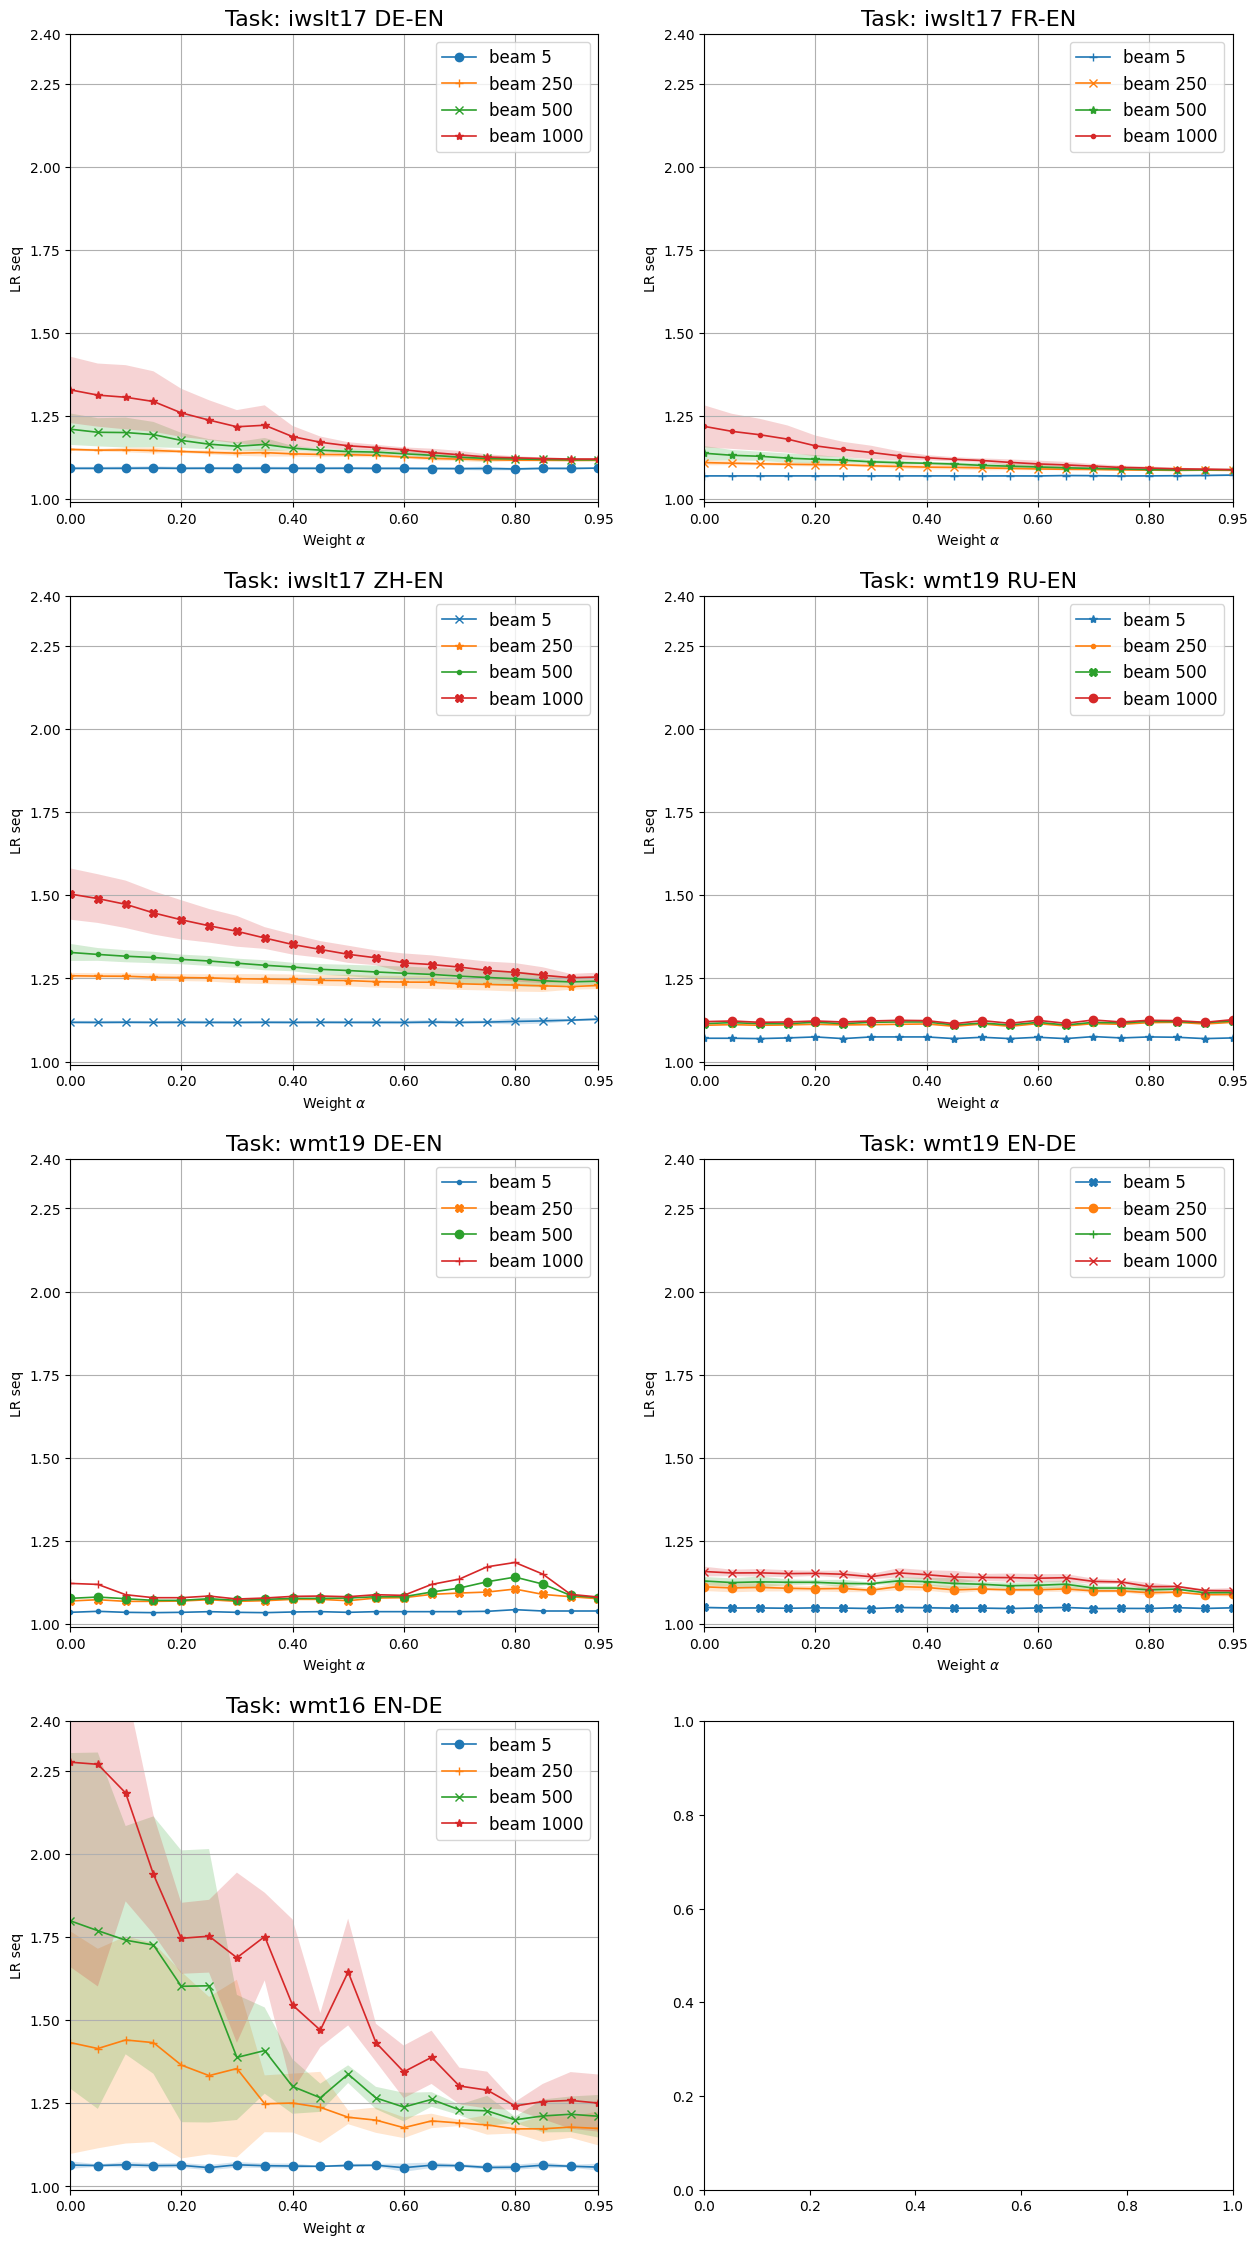

In [45]:
t = draw_plots_oversmoothing(experiments, 'LR seq', on_one_plot=False, 
                             base_path='/scratch/mae9785/oversmoothing_results_1512/', 
                             target=False,  beams=(5,250,500,1000),
                             print_title=True)

### Figure 5: BLEU scores

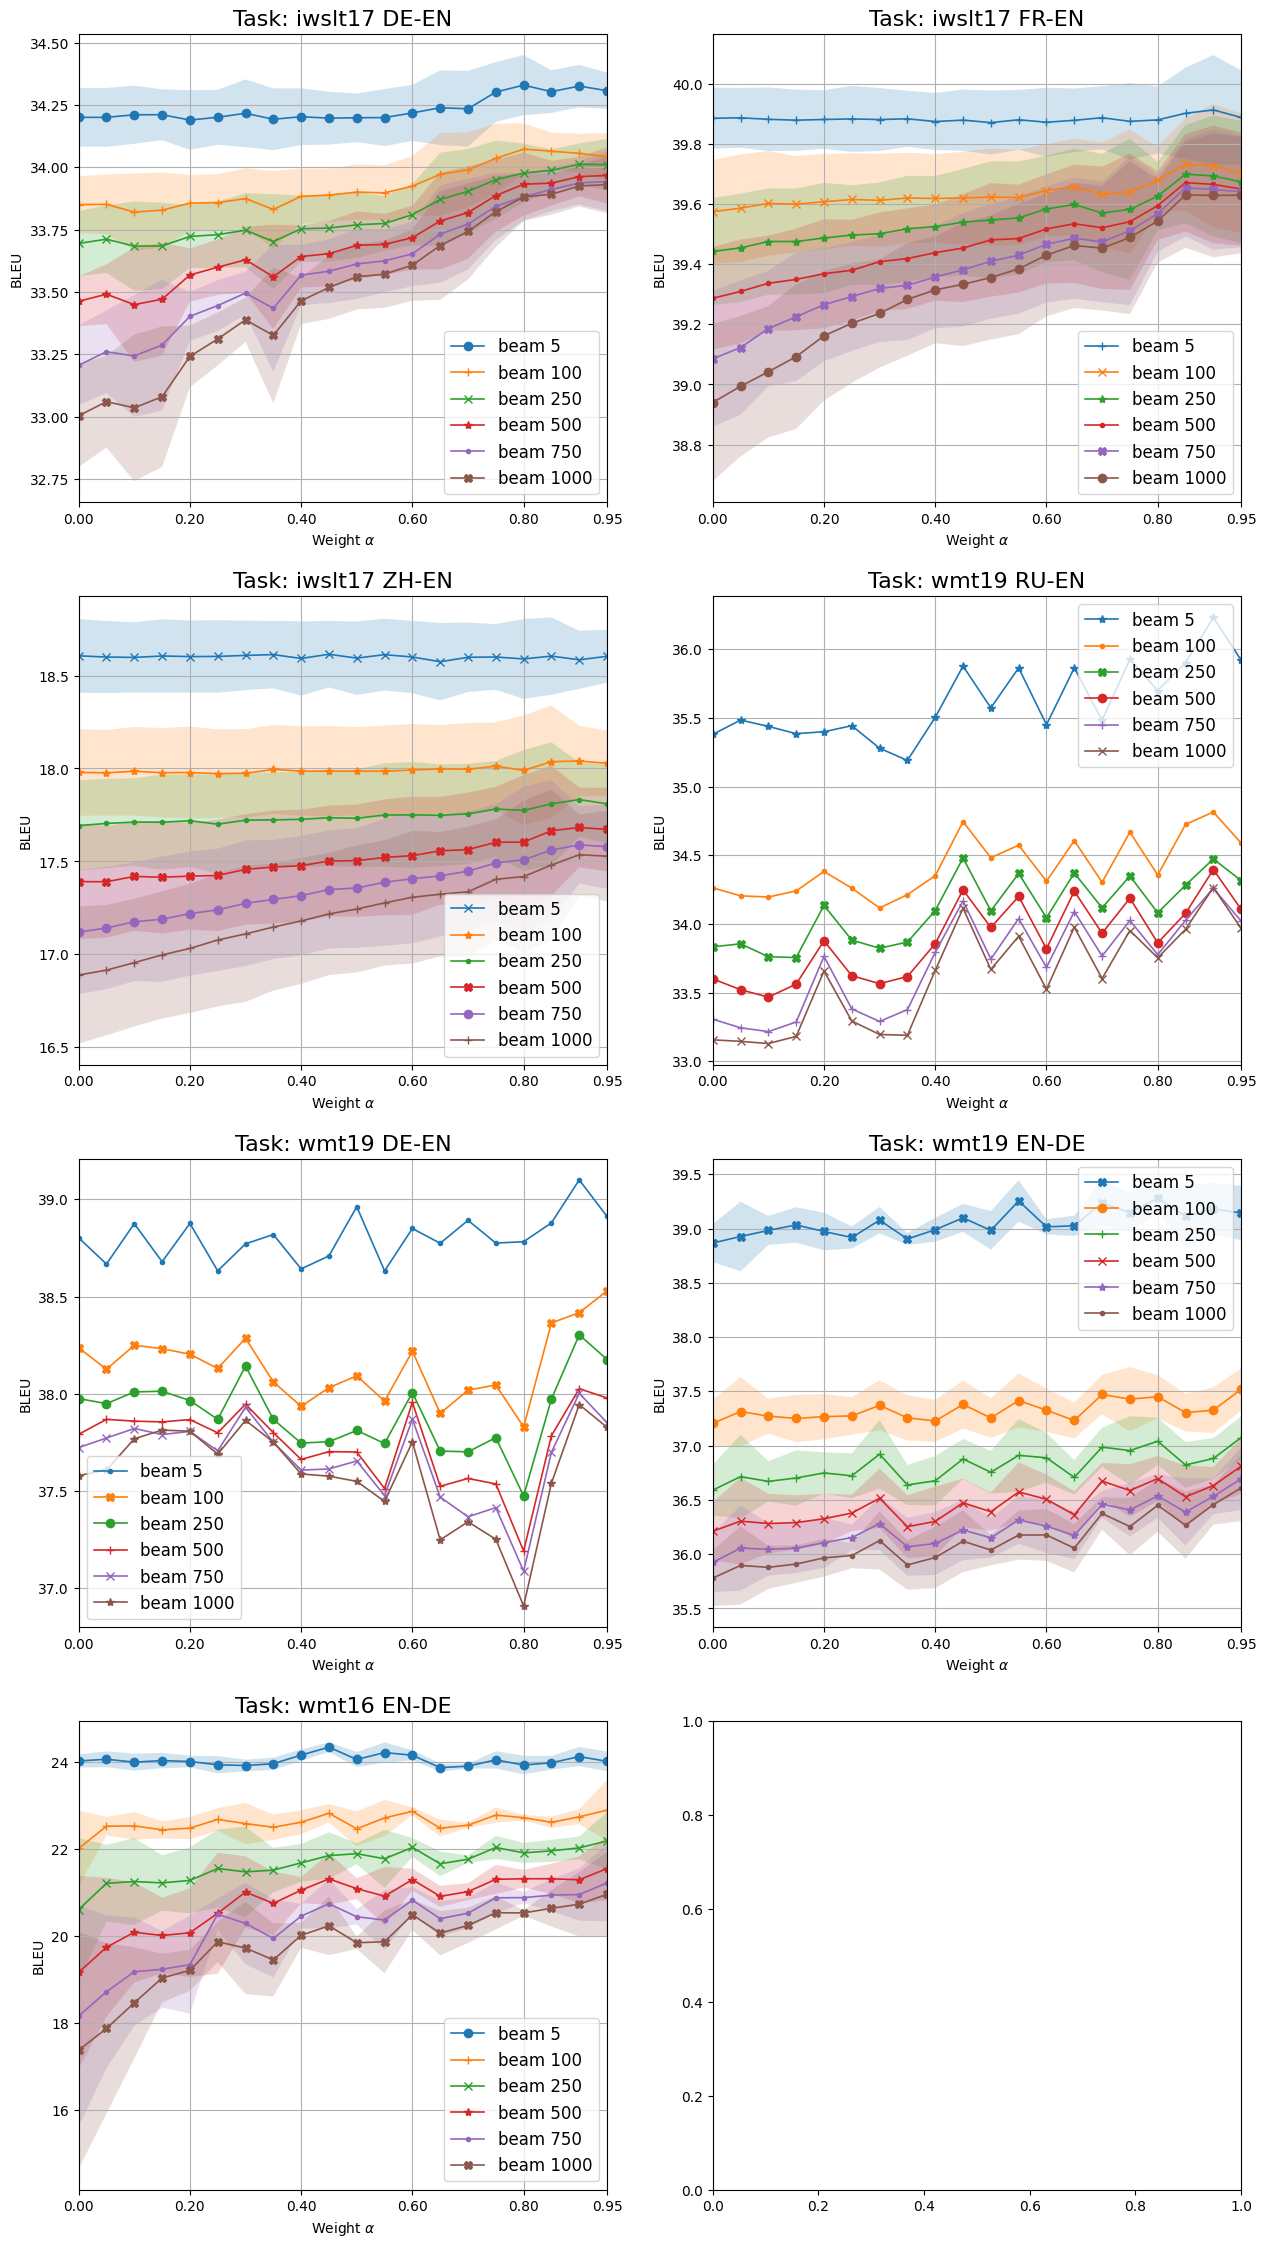

In [48]:
t = draw_plots_oversmoothing(experiments, 'BLEU', on_one_plot=False, 
                             base_path='/scratch/mae9785/oversmoothing_results_1512/', 
                             target=False,  beams=(5,100,250,500,750,1000),
                             print_title=True)